In [1]:
import torch
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
!pip install pyro-ppl

In [4]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

from pyro.infer import MCMC, NUTS, Predictive

In [5]:
# Real Observations

t_obs = torch.linspace(0., 5., 100).unsqueeze(-1)          # 100 × 1
u_true = 0.5*t_obs**2 + t_obs
noise = 0.1
u_obs = u_true + noise * torch.randn_like(u_true)     # 100 X 1
u_obs = u_obs.squeeze()       # 100,


# Collocation Points
t_f = torch.linspace(0., 5., 70).unsqueeze(-1).requires_grad_(True)

# initial condition point
t_ic = torch.tensor([[0.0]])

In [6]:
class PhyBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=50):
        super().__init__()

        self.activation = nn.Tanh()  
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., 10.).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., 10.).expand([hid_dim]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(0., 1.).expand([out_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., 10.).expand([out_dim]).to_event(1))

    
    def neural_net(self,t):
        h_1 = self.activation(self.layer1(t))
        h_2 = self.activation(self.layer2(h_1))
        return self.layer3(h_2).squeeze(-1)
    

    def forward(self,t_f,t_ic = None):
        #t_f = t_f.requires_grad_(True)
        # u_pred_obs = self.neural_net(t_obs)
        # u_ic = self.neural_net(t_ic)
        # u_f = self.neural_net(t_f)

        # du_dt = autograd.grad(u_f,t_f,grad_outputs=torch.ones_like(u_f),create_graph=True)[0].squeeze(-1)
        # res_pde =  du_dt - t_f.squeeze(-1)

        # res_ic = u_ic - 0.0
        

    # def forward(self, t_obs, u_obs=None):
    #     t = t_obs.reshape(-1, 1)
    #     h_1 = self.activation(self.layer1(t))
    #     h_2 = self.activation(self.layer2(h_1))
    #     u_pred_obs = self.layer3(h_2).squeeze()

        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise
        
    

        # if u_obs is not None:
        #     with pyro.plate("data", t_obs.shape[0]):
        #         pyro.sample("obs", dist.Normal(u_pred_obs, sigma * sigma), obs=u_obs)

        if t_f is not None:
            t_f = t_f.requires_grad_(True)
            u_pred_f = self.neural_net(t_f).squeeze(-1)
            du_dt = autograd.grad(u_pred_f,t_f,grad_outputs=torch.ones_like(u_pred_f),create_graph=True)[0].squeeze(-1)
            res_pde =  du_dt - t_f.squeeze(-1)
            with pyro.plate("physics",t_f.shape[0]):
                pyro.sample("pde", dist.Normal(res_pde, sigma * sigma), obs=torch.zeros_like(res_pde))

        if t_ic is not None:
            u_pred_ic = self.neural_net(t_ic).squeeze(-1)
            res_ic = u_pred_ic - 0.0
            with pyro.plate("initial",t_ic.shape[0]):
                pyro.sample("ic", dist.Normal(res_ic, sigma * sigma), obs=torch.zeros_like(res_ic))




    #     # Data Likelihood
        # with pyro.plate("data", t_obs.shape[0]):
        #     pyro.sample("obs", dist.Normal(u_pred_obs, sigma * sigma), obs=u_obs)
        #       #obs = pyro.sample("obs", dist.Normal(u_pred_obs, sigma * sigma), obs=u_obs)

        # IC Likelihood
        # with pyro.plate("initial",t_ic.shape[0]):
        #     pyro.sample("ic", dist.Normal(res_ic, sigma * sigma), obs=torch.zeros_like(res_ic))

        # PDE Likelihood
        # with pyro.plate("physics",t_f.shape[0]):
        #     pyro.sample("pde", dist.Normal(res_pde, sigma * sigma), obs=torch.zeros_like(res_pde))


        #return u_pred_f if t_f is not None else u_pred_obs

        if t_f is not None:
            return u_pred_f
        if t_ic is not None:
            return u_pred_ic
        return None

In [7]:
model_phy = PhyBNN()

pyro.set_rng_seed(42)

nuts_kernel = NUTS(model_phy, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=20, warmup_steps=10, num_chains=1)

with torch.enable_grad():
    mcmc.run(t_f, t_ic)



#mcmc.run(t_obs,u_obs,t_f, t_ic)

posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 30/30 [00:10,  2.86it/s, step size=6.80e-04, acc. prob=0.017]


In [8]:
for name, vals in posterior_samples.items():
    print(name, vals.shape)

layer1.bias torch.Size([20, 50])
layer1.weight torch.Size([20, 50, 1])
layer2.bias torch.Size([20, 50])
layer2.weight torch.Size([20, 50, 50])
layer3.bias torch.Size([20, 1])
layer3.weight torch.Size([20, 1, 50])
sigma torch.Size([20])


In [9]:
from pyro.poutine import uncondition

predictive_model = uncondition(model_phy)

predictive = Predictive(predictive_model, posterior_samples = posterior_samples, return_sites=["pde","ic"])

t_test = torch.linspace(0.,5.,1000).unsqueeze(-1).requires_grad_(True)


preds = predictive(t_test)




print(preds)



print(preds.keys())
for name, tensor in preds.items():
    print(f"{name!r} → shape {tuple(tensor.shape)}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
     Trace Shapes:        
      Param Sites:        
     Sample Sites:        
        sigma dist |      
             value |      
layer1.weight dist | 50  1
             value | 50  1
  layer1.bias dist | 50   
             value | 50   
layer2.weight dist | 50 50
             value | 50 50
  layer2.bias dist | 50   
             value | 50   
layer3.weight dist |  1 50
             value |  1 50
  layer3.bias dist |  1   
             value |  1   

In [ ]:
t_test_np = t_test.cpu().numpy().ravel()      # shape (1000,)
u_samples = preds["obs"].cpu().numpy()        # shape (num_samples, 1000)


mean_pred = u_samples.mean(axis=0)            # (1000,)
lower     = np.percentile(u_samples, 2.5, axis=0)
upper     = np.percentile(u_samples, 97.5, axis=0)


u_true = 0.5 * t_test_np**2 + t_test_np


t_obs_np = t_obs.squeeze(-1).cpu().numpy()    # (50,)
u_obs_np = u_obs.cpu().numpy()                # (50,)

# Plot
plt.figure(figsize=(8, 5))
plt.fill_between(t_test_np, lower, upper, alpha=0.3, label="95% credible interval")
plt.plot(t_test_np, mean_pred,label="Predictive mean")
plt.scatter(t_obs_np, u_obs_np,   marker='x', color='k', label="Data")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Posterior Predictive Distribution (Physics‑Informed BNN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Stage 2: Condition on data, starting from the physics‐informed posterior


mean_w1 = posterior_samples["layer1.weight"].mean(0)
std_w1  = posterior_samples["layer1.weight"].std(0)

print(mean_w1.shape)

mean_b1 = posterior_samples["layer1.bias"].mean(0)
std_b1 = posterior_samples["layer1.bias"].std(0)

print(mean_b1.shape)





mean_w2 = posterior_samples["layer2.weight"].mean(0)
std_w2  = posterior_samples["layer2.weight"].std(0)

mean_b2 = posterior_samples["layer2.bias"].mean(0)
std_b2 = posterior_samples["layer2.bias"].std(0)





mean_w3 = posterior_samples["layer3.weight"].mean(0)
std_w3  = posterior_samples["layer3.weight"].std(0)

mean_b3 = posterior_samples["layer3.bias"].mean(0)
std_b3 = posterior_samples["layer3.bias"].std(0)

torch.Size([50, 1])
torch.Size([50])


In [ ]:
# class BNN(PyroModule):
#     def __init__(self, in_dim=1, out_dim=1, hid_dim=50, prior_scale=10.):
#         super().__init__()

#         self.activation = nn.Tanh()  
#         self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
#         self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
#         self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

#         # Set layer parameters as random variables
#         self.layer1.weight = PyroSample(dist.Normal(mean_w1, std_w1).expand([hid_dim, in_dim]).to_event(2))
#         self.layer1.bias = PyroSample(dist.Normal(mean_b1, std_b1).expand([hid_dim]).to_event(1))
#         self.layer2.weight = PyroSample(dist.Normal(mean_w2, std_w2).expand([hid_dim, hid_dim]).to_event(2))
#         self.layer2.bias = PyroSample(dist.Normal(mean_b2, std_b2).expand([hid_dim]).to_event(1))
#         self.layer3.weight = PyroSample(dist.Normal(mean_w3, std_w3).expand([out_dim, hid_dim]).to_event(2))
#         self.layer3.bias = PyroSample(dist.Normal(mean_b3, std_b3).expand([out_dim]).to_event(1))

    
#     def neural_net_2(self,t):
#         z_1 = self.activation(self.layer1(t))
#         z_2 = self.activation(self.layer2(z_1))
#         return self.layer3(z_2).squeeze(-1)
    

#     def forward(self,t_obs, u_obs = None, t_f = None, t_ic = None):
#         u_pred_obs = self.neural_net_2(t_obs)
#         sigma_2 = pyro.sample("sigma_2", dist.Gamma(.5, 1))

       
#         with pyro.plate("data", t_obs.shape[0]):
#             pyro.sample("obs", dist.Normal(u_pred_obs, sigma_2 * sigma_2), obs=u_obs)


#         if t_f is not None:
#             t_f = t_f.requires_grad_(True)
#             u_pred_f_2 = self.neural_net_2(t_f).squeeze(-1)
#             du_dt = autograd.grad(u_pred_f_2,t_f,grad_outputs=torch.ones_like(u_pred_f_2),create_graph=True)[0].squeeze(-1)
#             res_pde_2 =  du_dt - t_f.squeeze(-1)
#             with pyro.plate("physics",t_f.shape[0]):
#                 pyro.sample("pde", dist.Normal(res_pde_2, sigma_2 * sigma_2), obs=torch.zeros_like(res_pde_2))


#         if t_ic is not None:
#             u_pred_ic_2 = self.neural_net_2(t_ic).squeeze(-1)
#             res_ic_2 = u_pred_ic_2 - 0.0
#             with pyro.plate("initial",t_ic.shape[0]):
#                 pyro.sample("ic", dist.Normal(res_ic_2, sigma_2 * sigma_2), obs=torch.zeros_like(res_ic_2))



#         return u_pred_obs

        

        

        

In [ ]:
# # With Non-Gaussian Residual (Gamma)

# class BNN(PyroModule):
#     def __init__(self, in_dim=1, out_dim=1, hid_dim=50, prior_scale=10.):
#         super().__init__()

#         self.activation = nn.Tanh()  
#         self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
#         self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
#         self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

#         # Set layer parameters as random variables
#         self.layer1.weight = PyroSample(dist.Normal(mean_w1, std_w1).expand([hid_dim, in_dim]).to_event(2))
#         self.layer1.bias = PyroSample(dist.Normal(mean_b1, std_b1).expand([hid_dim]).to_event(1))
#         self.layer2.weight = PyroSample(dist.Normal(mean_w2, std_w2).expand([hid_dim, hid_dim]).to_event(2))
#         self.layer2.bias = PyroSample(dist.Normal(mean_b2, std_b2).expand([hid_dim]).to_event(1))
#         self.layer3.weight = PyroSample(dist.Normal(mean_w3, std_w3).expand([out_dim, hid_dim]).to_event(2))
#         self.layer3.bias = PyroSample(dist.Normal(mean_b3, std_b3).expand([out_dim]).to_event(1))

    
#     def neural_net_2(self,t):
#         z_1 = self.activation(self.layer1(t))
#         z_2 = self.activation(self.layer2(z_1))
#         return self.layer3(z_2).squeeze(-1)
    

#     def forward(self,t_obs, u_obs = None, t_f = None, t_ic = None):
#         u_pred_obs = self.neural_net_2(t_obs)
#         sigma_2 = pyro.sample("sigma_2", dist.Gamma(.5, 1))
       
        
#         k     = pyro.sample("k", dist.Gamma(2.0, 0.5))
#         theta = pyro.sample("theta", dist.HalfCauchy(1.0))
#         with pyro.plate("data", t_obs.shape[0]):
                
#                 if u_obs is not None:
#                     r = (u_obs - u_pred_obs).clamp(min=0)
                    
#                     pyro.sample("obs", dist.Gamma(concentration=k, rate = 1.0/theta), obs=r)

#                 else:
#                     r = pyro.sample("obs",dist.Gamma(concentration=k, rate=1.0/theta))
#                     u_pred_obs = pyro.deterministic("u_pred_plus_r",u_pred_obs + r)


                    
#         # with pyro.plate("data", t_obs.shape[0]):
#         #     r = (u_obs - u_pred_obs).clamp(min=0)
#         #     pyro.sample("obs", dist.Gamma(concentration=k, rate = 1.0/theta), obs=r)

    


       
            
           


#         if t_f is not None:
#             t_f = t_f.requires_grad_(True)
#             u_pred_f_2 = self.neural_net_2(t_f).squeeze(-1)
#             du_dt = autograd.grad(u_pred_f_2,t_f,grad_outputs=torch.ones_like(u_pred_f_2),create_graph=True)[0].squeeze(-1)
#             res_pde_2 =  du_dt - t_f.squeeze(-1)
#             with pyro.plate("physics",t_f.shape[0]):
#                 pyro.sample("pde", dist.Normal(res_pde_2, sigma_2 * sigma_2), obs=torch.zeros_like(res_pde_2))


#         if t_ic is not None:
#             u_pred_ic_2 = self.neural_net_2(t_ic).squeeze(-1)
#             res_ic_2 = u_pred_ic_2 - 0.0
#             with pyro.plate("initial",t_ic.shape[0]):
#                 pyro.sample("ic", dist.Normal(res_ic_2, sigma_2 * sigma_2), obs=torch.zeros_like(res_ic_2))



#         return u_pred_obs


In [141]:
#With Non-Gaussian Residuals (Exponential)

class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=50, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(mean_w1, std_w1).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(mean_b1, std_b1).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(mean_w2, std_w2).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(mean_b2, std_b2).expand([hid_dim]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(mean_w3, std_w3).expand([out_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(mean_b3, std_b3).expand([out_dim]).to_event(1))

    
    def neural_net_2(self,t):
        z_1 = self.activation(self.layer1(t))
        z_2 = self.activation(self.layer2(z_1))
        return self.layer3(z_2).squeeze(-1)
    

    def forward(self,t_obs, u_obs = None, t_f = None, t_ic = None):
        u_pred_obs = self.neural_net_2(t_obs)
        sigma_2 = pyro.sample("sigma_2", dist.Gamma(.5, 1))

        

        lambda_1 = pyro.sample("lambda", dist.HalfCauchy(1.0))

        with pyro.plate("data", t_obs.shape[0]):
            if u_obs is not None:
                r = (u_obs - u_pred_obs).clamp(min=0)
                pyro.sample("obs", dist.Exponential(rate = lambda_1), obs=r)
            else:
                r = pyro.sample("obs", dist.Exponential(rate=lambda_1))
                pyro.deterministic("u_pred_plus_r", u_pred_obs + r)


        
                    
                    

       


       
        # with pyro.plate("data", t_obs.shape[0]):
        #     pyro.sample("obs", dist.Exponential(rate = lambda_1), obs=r)


        if t_f is not None:
            t_f = t_f.requires_grad_(True)
            u_pred_f_2 = self.neural_net_2(t_f).squeeze(-1)
            du_dt = autograd.grad(u_pred_f_2,t_f,grad_outputs=torch.ones_like(u_pred_f_2),create_graph=True)[0].squeeze(-1)
            res_pde_2 =  du_dt - t_f.squeeze(-1)
            with pyro.plate("physics",t_f.shape[0]):
                pyro.sample("pde", dist.Normal(res_pde_2, sigma_2 * sigma_2), obs=torch.zeros_like(res_pde_2))


        if t_ic is not None:
            u_pred_ic_2 = self.neural_net_2(t_ic).squeeze(-1)
            res_ic_2 = u_pred_ic_2 - 0.0
            with pyro.plate("initial",t_ic.shape[0]):
                pyro.sample("ic", dist.Normal(res_ic_2, sigma_2 * sigma_2), obs=torch.zeros_like(res_ic_2))



        return u_pred_obs


In [ ]:
# With Non-Gaussian Residuals (Student's T)

In [146]:
model_2 = BNN()

pyro.clear_param_store()
torch.manual_seed(42)

pyro.set_rng_seed(42)

nuts_2 = NUTS(model_2, jit_compile=False)
mcmc_2 = MCMC(nuts_2, num_samples=200, warmup_steps=100, num_chains=1)

with torch.enable_grad():
    mcmc_2.run(t_obs, u_obs, t_f, t_ic)



#mcmc.run(t_obs,u_obs,t_f, t_ic)

posterior_samples_2 = mcmc_2.get_samples()

Sample: 100%|██████████| 300/300 [05:28,  1.09s/it, step size=1.50e-02, acc. prob=0.123]


In [147]:
for name, vals in posterior_samples_2.items():
    print(f"{name:15s} → {tuple(vals.shape)}")

lambda          → (200,)
layer1.bias     → (200, 50)
layer1.weight   → (200, 50, 1)
layer2.bias     → (200, 50)
layer2.weight   → (200, 50, 50)
layer3.bias     → (200, 1)
layer3.weight   → (200, 1, 50)
sigma_2         → (200,)


In [148]:
from pyro.poutine import uncondition

predictive_model = uncondition(model_2)

predictive = Predictive(predictive_model, posterior_samples = posterior_samples_2, return_sites=["obs"])

t_test = torch.linspace(0.,5.,1000).unsqueeze(-1)

preds = predictive(t_test)




print(preds)



print(preds.keys())
for name, tensor in preds.items():
    print(f"{name!r} → shape {tuple(tensor.shape)}")

{'obs': tensor([[ 1.3563,  1.2899,  1.0457,  ...,  2.3654,  0.0987, 23.0096],
        [ 1.5689,  1.1588,  0.3081,  ...,  8.1824,  1.0134,  1.7429],
        [ 0.4392,  1.3591,  0.7029,  ...,  0.9121,  0.9677,  1.7322],
        ...,
        [ 0.0797,  0.0568,  0.2430,  ...,  0.2056,  0.0284,  0.0266],
        [ 0.0301,  0.1777,  0.0722,  ...,  0.6409,  0.0687,  0.0545],
        [ 0.4173,  0.4288,  0.1263,  ...,  0.3828,  0.0986,  0.0274]])}
dict_keys(['obs'])
'obs' → shape (200, 1000)


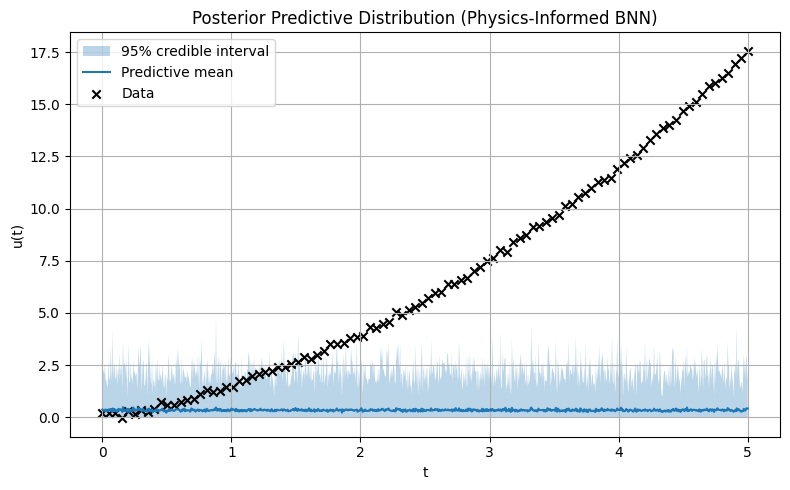

In [ ]:
# t_test_np = t_test.cpu().numpy().ravel()      # shape (1000,)
# u_samples = preds["obs"].cpu().numpy()        # shape (num_samples, 1000)


# mean_pred = u_samples.mean(axis=0)            # (1000,)
# lower     = np.percentile(u_samples, 2.5, axis=0)
# upper     = np.percentile(u_samples, 97.5, axis=0)


# u_true = 0.5 * t_test_np**2 + t_test_np


# t_obs_np = t_obs.squeeze(-1).cpu().numpy()    # (50,)
# u_obs_np = u_obs.cpu().numpy()                # (50,)

# # Plot
# plt.figure(figsize=(8, 5))
# plt.fill_between(t_test_np, lower, upper, alpha=0.3, label="95% credible interval")
# plt.plot(t_test_np, mean_pred,label="Predictive mean")
# plt.scatter(t_obs_np, u_obs_np,   marker='x', color='k', label="Data")
# plt.xlabel("t")
# plt.ylabel("u(t)")
# plt.title("Posterior Predictive Distribution (Physics‑Informed BNN)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()